<a href="https://colab.research.google.com/github/owen-yeung/ML-Self-Study/blob/main/UMich_fully_connected_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 3-1: Fully-Connected Neural Networks and Dropout

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Owen Yeung, #XXXXXXXX

# Fully-connected neural networks
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer as a tool to more efficiently optimize deep networks.
  

## Install starter code
We will continue using the utility functions that we've used for Assignment 1 and 2: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-5bplnfa7
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-5bplnfa7
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10266 sha256=f9abcefe915d6b9c94e5435ea02285964ed2fc258afaa93db90bdcfefb5c9054
  Stored in directory: /tmp/pip-ephem-wheel-cache-68kqeoom/wheels/c9/fa/82/64b6c443adccf6982835123e4300fc4420373c553439ff0ad5
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [22]:
import math
import torch
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, Solver
import matplotlib.pyplot as plt

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

## Load CIFAR-10 data
Here we provide a function to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [3]:
def get_CIFAR10_data(validation_ratio=0.05, cuda=False, reshape_to_2d=False,
                     visualize=False):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Load every data on cuda
  if cuda:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  if visualize:
    img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  if reshape_to_2d:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Take the validation set from the training set
  # Note: It should not be taken from the test set
  # For random permumation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # return the dataset
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

100%|██████████| 170498071/170498071 [00:03<00:00, 43429478.74it/s]


Extracting ./cifar-10-python.tar.gz to .


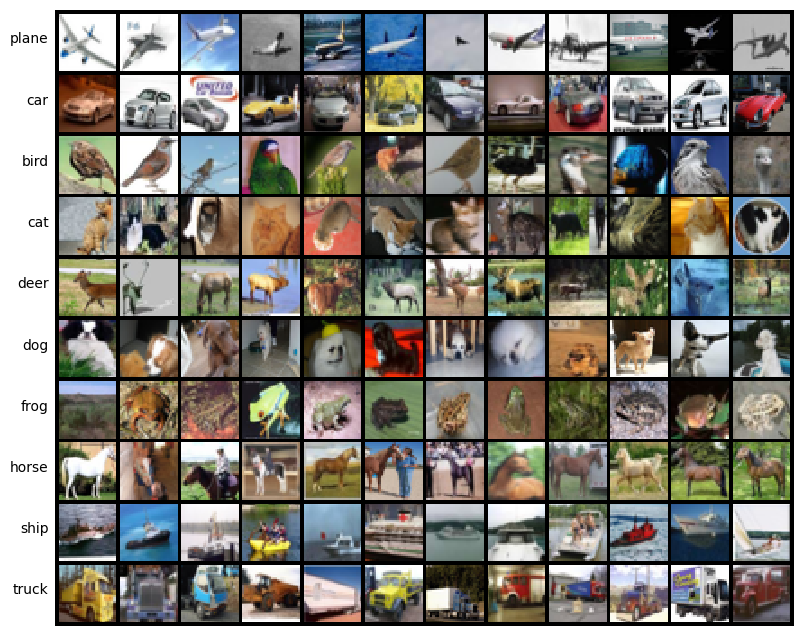

Train data shape:  torch.Size([47500, 3, 32, 32])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3, 32, 32])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [4]:
# Invoke the above function to get our data.
data_dict = get_CIFAR10_data(visualize=True)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Linear layer

For each layer we implement, we will define a class with two static methods `forward` and `backward`.

For now the `forward` and `backward` methods are stubs. We will actually implement them in the following cells.

In [5]:
class Linear(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Linear layer: forward
Implement the `Linear.forward` function. Once you are done you can test your implementaion by running the next cell:

In [6]:
def linear_forward(x, w, b):
  """
  Computes the forward pass for an linear (fully-connected) layer.
  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.
  Inputs:
  - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
  - w: A tensor of weights, of shape (D, M)
  - b: A tensor of biases, of shape (M,)
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  #############################################################################
  # TODO: Implement the linear forward pass. Store the result in out. You     #
  # will need to reshape the input into rows.                                 #
  #############################################################################
  # Replace "pass" statement with your code

  N = x.shape[0]
  x_reshape = x.reshape(N,-1)
  out = x_reshape.mm(w) + b

  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, w, b)
  return out, cache

Linear.forward = linear_forward

Test the `Linear.forward` function. You should see errors less than `1e-8`.

In [7]:
# Test the Linear.forward function
num_inputs = 2
input_shape = torch.tensor((4, 5, 6))
output_dim = 3

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, **to_double_cuda).reshape(num_inputs, *input_shape)
w = torch.linspace(-0.2, 0.3, steps=weight_size, **to_double_cuda).reshape(torch.prod(input_shape), output_dim)
b = torch.linspace(-0.3, 0.1, steps=output_dim, **to_double_cuda)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[ 1.49834967,  1.70660132,  1.91485297],
                            [ 3.25553199,  3.5141327,   3.77273342]],
                            **to_double_cuda)

print('Testing Linear.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing Linear.forward function:
difference:  1.9539697795885023e-09


## Linear layer: backward
Now implement the `Linear.backward` function and test your implementation using numeric gradient checking.

In [8]:
def linear_backward(dout, cache):
  """
  Computes the backward pass for an linear layer.
  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)
    - b: Biases, of shape (M,)
  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  #############################################################################
  # TODO: Implement the linear backward pass.                                 #
  #############################################################################
  # Replace "pass" statement with your code
  N = x.shape[0]
  x_reshaped = x.reshape(N,-1)
  db = dout.sum(dim = 0)
  dw = x_reshaped.T.mm(dout)
  dx = dout.mm(w.T).reshape(x.shape)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx, dw, db

Linear.backward = linear_backward

Run the following to test your implementation of `Linear.backward`. You should see errors less than `1e-8`.

In [9]:
# Test the Linear.backward function
fix_random_seed(0)
x = torch.randn(10, 2, 3, **to_double_cuda)
w = torch.randn(6, 5, **to_double_cuda)
b = torch.randn(5, **to_double_cuda)
dout = torch.randn(10, 5, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear.backward function:
dx error:  2.340771536181963e-09
dw error:  6.573349127694478e-11
db error:  4.357966842062988e-11


# ReLU activation

We will now implement the ReLU nonlinearity. As above, we will define a class with two empty static methods, and implement them in upcoming cells.

In [10]:
class ReLU(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `ReLU.forward` function.

You should not change the input tensor with an in-place operation.

In [11]:
def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).
  Input:
  - x: Input; a tensor of any shape
  Returns a tuple of:
  - out: Output, a tensor of the same shape as x
  - cache: x
  """
  out = None
  #############################################################################
  # TODO: Implement the ReLU forward pass.                                    #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  out = x.clone()
  out[out < 0] = 0
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = x
  return out, cache

ReLU.forward = relu_forward

Run the following to test your implementation of the ReLU forward pass. Your errors should be less than `1e-7`.

In [12]:
# Test the relu_forward function
x = torch.linspace(-0.5, 0.5, steps=12, **to_double_cuda).reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            **to_double_cuda)

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  9.999999034982122e-08


## ReLU activation: backward
Now implement the backward pass for the ReLU activation function.

Again, you should not change the input tensor with an in-place operation.

In [13]:
def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).
  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout
  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  #############################################################################
  # TODO: Implement the ReLU backward pass.                                   #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  dx = dout.clone()
  dx[x<=0]=0
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx

ReLU.backward = relu_backward

Run the following to test your implementation of `ReLU.backward`. Your errors should be less than `1e-10`.

In [14]:
fix_random_seed(0)
x = torch.randn(10, 10, **to_double_cuda)
dout = torch.randn(*x.shape, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  6.5510464861138194e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.

For now take a look at the `forward` and `backward` functions in `Linear_ReLU`, and run the following to numerically gradient check the backward pass:

In [15]:
class Linear_ReLU(object):

  @staticmethod
  def forward(x, w, b):
    """
    Convenience layer that perorms an linear transform followed by a ReLU.

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = Linear.forward(x, w, b)
    out, relu_cache = ReLU.forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db

Run the following to test the implementation of the `Linear_ReLU` layer using numeric gradient checking. You should see errors less than `1e-8`

In [16]:
fix_random_seed(0)
x = torch.randn(2, 3, 4, **to_double_cuda)
w = torch.randn(12, 10, **to_double_cuda)
b = torch.randn(10, **to_double_cuda)
dout = torch.randn(2, 10, **to_double_cuda)

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  3.3612885869824705e-10
dw error:  1.8447601369756057e-09
db error:  5.0959990317728124e-11


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations.

You can make sure that the implementations are correct by running the following:

In [17]:
def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[torch.arange(N), y]
  margins = (x - correct_class_scores[:, None] + 1.0).clamp(min=0.)
  margins[torch.arange(N), y] = 0.
  loss = margins.sum() / N
  num_pos = (margins > 0).sum(dim=1)
  dx = torch.zeros_like(x)
  dx[margins > 0] = 1.
  dx[torch.arange(N), y] -= num_pos.to(dx.dtype)
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  shifted_logits = x - x.max(dim=1, keepdim=True).values
  Z = shifted_logits.exp().sum(dim=1, keepdim=True)
  log_probs = shifted_logits - Z.log()
  probs = log_probs.exp()
  N = x.shape[0]
  loss = (-1.0/ N) * log_probs[torch.arange(N), y].sum()
  dx = probs.clone()
  dx[torch.arange(N), y] -= 1
  dx /= N
  return loss, dx

Run the following to perform numeric gradient checking on the two loss functions. You should see errors less than `1e-7`.

In [18]:
fix_random_seed(0)
num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

dx_num = compute_numeric_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

dx_num = compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.000430792478463
dx error:  2.8043130317900733e-09

Testing softmax_loss:
loss:  2.3026286102347924
dx error:  1.9329571390449453e-08


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [19]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  The architecure should be linear - relu - linear - softmax.
  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to PyTorch tensors.
  """

  def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
         weight_scale=1e-3, reg=0.0, dtype=torch.float32, device='cpu'):
    """
    Initialize a new network.
    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dim: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.params = {}
    self.reg = reg

    ###########################################################################
    # TODO: Initialize the weights and biases of the two-layer net. Weights   #
    # should be initialized from a Gaussian centered at 0.0 with              #
    # standard deviation equal to weight_scale, and biases should be          #
    # initialized to zero. All weights and biases should be stored in the     #
    # dictionary self.params, with first layer weights                        #
    # and biases using the keys 'W1' and 'b1' and second layer                #
    # weights and biases using the keys 'W2' and 'b2'.                        #
    ###########################################################################
    # Replace "pass" statement with your code
    self.W1_shape = (input_dim, hidden_dim)
    self.b1_shape = (1, hidden_dim)
    self.W2_shape = (hidden_dim, num_classes)
    self.b2_shape = (1, num_classes)
    self.params['W1'] = torch.normal(0, weight_scale, size=self.W1_shape,
                                     dtype=dtype, device=device)
    self.params['b1'] = torch.zeros(self.b1_shape,
                                    dtype=dtype, device=device)
    self.params['W2'] = torch.normal(0, weight_scale, size=self.W2_shape,
                                     dtype=dtype, device=device)
    self.params['b2'] = torch.zeros(self.b2_shape,
                                    dtype=dtype, device=device)

    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################


  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Tensor of input data of shape (N, d_1, ..., d_k)
    - y: int64 Tensor of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Tensor of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.
    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """
    scores = None
    ###########################################################################
    # TODO: Implement the forward pass for the two-layer net, computing the   #
    # class scores for X and storing them in the scores variable.             #
    ###########################################################################
    # Replace "pass" statement with your code
    x2, cache1 = Linear_ReLU.forward(X, self.params['W1'], self.params['b1'])
    scores, cache2 = linear_forward(x2, self.params['W2'], self.params['b2'])

    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores

    loss, grads = 0, {}
    ###########################################################################
    # TODO: Implement the backward pass for the two-layer net. Store the loss #
    # in the loss variable and gradients in the grads dictionary. Compute data#
    # loss using softmax, and make sure that grads[k] holds the gradients for #
    # self.params[k]. Don't forget to add L2 regularization!                  #
    #                                                                         #
    # NOTE: To ensure that your implementation matches ours and you pass the  #
    # automated tests, make sure that your L2 regularization does not include #
    # a factor of 0.5.                                                        #
    ###########################################################################
    # Replace "pass" statement with your code
    l2_regularization_loss = self.reg * (
        (self.params['W1'] ** 2).sum() +
        (self.params['W2'] ** 2).sum()
        )
    data_loss, dscores = softmax_loss(scores, y)
    loss = l2_regularization_loss + data_loss
    #Compute grads
    dx2, dW2, grads['b2'] = linear_backward(dscores, cache2)
    grads['W2'] = 2 * self.reg * self.params['W2'] + dW2
    dx1, dW1, grads['b1'] = Linear_ReLU.backward(dx2, cache1)
    grads['W1'] = 2 * self.reg * self.params['W1'] + dW1
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    return loss, grads

Once you have finished implementing the forward and backward passes of your two-layer net, run the following to test your implementation:

In [20]:
fix_random_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std,
                    **to_double_cuda)

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D*H, **to_double_cuda).reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, **to_double_cuda)
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H*C, **to_double_cuda).reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, **to_double_cuda)
X = torch.linspace(-5.5, 4.5, steps=N*D, **to_double_cuda).reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    **to_double_cuda)
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.43e-08
W2 relative error: 7.04e-10
b1 relative error: 2.04e-08
b2 relative error: 1.55e-09
Running numeric gradient check with reg =  0.7
W1 relative error: 5.74e-08
W2 relative error: 1.54e-05
b1 relative error: 3.13e-08
b2 relative error: 4.60e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Read through `help(Solver)` to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [23]:
print(help(Solver))

Help on class Solver in module coutils.solver:

class Solver(builtins.object)
 |  Solver(model, data, **kwargs)
 |  
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.loss_history will contain a list
 |  of all

In [25]:
fix_random_seed(0)
model = TwoLayerNet(dtype=torch.float, device='cuda')
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Replace "pass" statement with your code
solver = Solver(model, get_CIFAR10_data(), optim_config={'learning_rate': 0.1}, verbose=False, device='cuda')
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

RuntimeError: ignored

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout; we will add this feature soon.

In [26]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function.
  For a network with L layers, the architecture will be:

  {linear - relu - [dropout]} x (L - 1) - linear - softmax

  where dropout is optional, and the {...} block is repeated L - 1 times.

  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0.0, reg=0.0, weight_scale=1e-2, seed=None,
               dtype=torch.float, device='cpu'):
    """
    Initialize a new FullyConnectedNet.

    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving the drop probability for networks
      with dropout. If dropout=0 then the network should not use dropout.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.use_dropout = dropout != 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.device = device
    self.params = {}

    ############################################################################
    # TODO: Initialize the parameters of the network, storing all values in    #
    # the self.params dictionary. Store weights and biases for the first layer #
    # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
    # initialized from a normal distribution centered at 0 with standard       #
    # deviation equal to weight_scale. Biases should be initialized to zero.   #
    ############################################################################
    # Replace "pass" statement with your code
    dims = [input_dim] + hidden_dims + [num_classes]
    # List of all weight keys and bias keys for convenience
    # self.W_keys = self.b_keys = []
    for layer_number in range(1, self.num_layers + 1):
      W_key, b_key = f'W{layer_number}', f'b{layer_number}'
      self.params[W_key] = torch.normal(0, weight_scale, size=(dims[layer_number - 1], dims[layer_number]), dtype=dtype, device=device)
      self.params[b_key] = torch.zeros(1, dims[layer_number], dtype=dtype, device=device)
      # self.W_keys.append(W_key)
      # self.b_keys.append(b_key)

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.
    Input / output: Same as TwoLayerNet above.
    """
    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.use_dropout:
      self.dropout_param['mode'] = mode
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the fully-connected net, computing  #
    # the class scores for X and storing them in the scores variable.          #
    #                                                                          #
    # When using dropout, you'll need to pass self.dropout_param to each       #
    # dropout forward pass.                                                    #
    ############################################################################
    # Replace "pass" statement with your code
    caches = {}
    intermediate_X = X

    # Iterate over every layer except the last one, which has no RELU
    for layer_number in range(1, self.num_layers):
      W_key, b_key = f'W{layer_number}', f'b{layer_number}'
      intermediate_X, caches[f'c{layer_number}'] = Linear_ReLU.forward(intermediate_X, self.params[W_key], self.params[b_key])

    # Final layer has no RELU
    W_key, b_key = f'W{self.num_layers}', f'b{self.num_layers}'
    scores, caches[f'c{self.num_layers}'] = linear_forward(intermediate_X, self.params[W_key], self.params[b_key])

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    ############################################################################
    # TODO: Implement the backward pass for the fully-connected net. Store the #
    # loss in the loss variable and gradients in the grads dictionary. Compute #
    # data loss using softmax, and make sure that grads[k] holds the gradients #
    # for self.params[k]. Don't forget to add L2 regularization!               #
    # NOTE: To ensure that your implementation matches ours and you pass the   #
    # automated tests, make sure that your L2 regularization includes a factor #
    # of 0.5 to simplify the expression for the gradient.                      #
    ############################################################################
    # Replace "pass" statement with your code

    # compute data loss
    loss, dscores = softmax_loss(scores, y)
    # compute l2 regularize loss
    for i in range(1, self.num_layers + 1):
      W_key = f'W{i}'
      loss += (self.params[W_key] ** 2).sum() * self.reg * 0.5

    # gradient for final layer
    dx, dW, grads[f'b{self.num_layers}'] = linear_backward(dscores, caches[f'c{self.num_layers}'])
    grads[f'W{self.num_layers}'] = self.reg * self.params[f'W{self.num_layers}'] + dW

    # gradient for other layers
    for i in range(1, self.num_layers):
      layer_number = self.num_layers - i
      W_key, b_key = f'W{layer_number}', f'b{layer_number}'
      dx, dW, grads[b_key] = Linear_ReLU.backward(dx, caches[f'c{layer_number}'])
      grads[W_key] = self.reg * self.params[W_key] + dW
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return loss, grads

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors less than `1e-6`, except for the check on `W1` and `W2` with `reg=0` where your errors should be less than `1e-5`.

In [27]:
fix_random_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, **to_double_cuda)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3053575717037686
W1 relative error: 7.62e-06
W2 relative error: 3.47e-07
W3 relative error: 1.39e-07
b1 relative error: 4.20e-07
b2 relative error: 3.76e-09
b3 relative error: 2.34e-10
Running check with reg =  3.14
Initial loss:  7.293696337190991
W1 relative error: 3.07e-08
W2 relative error: 1.42e-07
W3 relative error: 3.70e-07
b1 relative error: 1.46e-07
b2 relative error: 4.39e-08
b3 relative error: 7.79e-10


Note: There was more in the original UMich notebook, but due to a bug in the provided Solver class I was not able to run any of the code after this point